In [1]:
import numpy as np
import pandas as pd
from pyens.models import Flywheel, OCV, EcmCell
from pyens.utilities import ivp
from pyens.simulations import Simulator, Data, Current, Learner
import os
import matplotlib.pyplot as plt

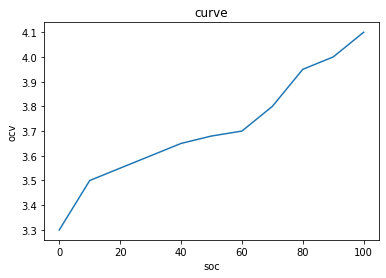

In [2]:
ocv = [3.3, 3.5, 3.55, 3.6, 3.65, 3.68, 3.70, 3.8, 3.95, 4.0, 4.1]
soc = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

c1 = OCV(name="curve1", ocv=ocv, soc=soc)

c1.display()

In [3]:
param = {
 "R0": 0.034,
 "R1": 0.022,
 "C1": 1500,
 "R2": 0.019,
 "C2": 65000,
 "CAP": 15,
 "ce": 0.96,
 "v_limits": [2.5, 4.5],
 "SOC_RANGE": [0.0, 100.0],
}

m1 = EcmCell(name="cell_model1", parameters=param, curve=c1)
m1.display()

In [4]:
dt = 0.1
CURR_EXCITATION = 7.5
HOUR = 3600.0
h_steps = [1.75, 0.25, 0.25, 0.25, 1, 1, 1]
current_steps = [
 -CURR_EXCITATION,
 -CURR_EXCITATION / 2,
 -CURR_EXCITATION / 4,
 -CURR_EXCITATION / 8,
 0.0,
 CURR_EXCITATION,
 0.0,
]

initial_soc = 0.0
t_steps = [value * HOUR for value in h_steps]
total_time = sum(t_steps)
samples = int(total_time / dt)

time_np = np.linspace(0.0, total_time, samples)
step_cur = Current(name="current1")

In [5]:
for t_step, current_step in zip(t_steps, current_steps):
 step_cur.add_step(current_step, int(t_step / dt))

data = {"time": time_np, "current": step_cur.current}
df = pd.DataFrame(data)
d1 = Data(name="current_excite", df=df)

In [6]:
s1 = Simulator(name="simulator1")
s1.attach(m1).attach(d1)

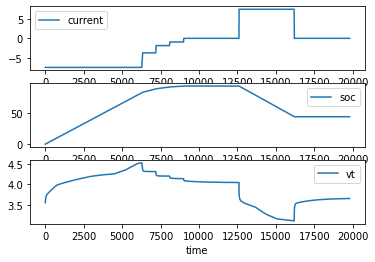

0      3.300000
1      3.300000
2      3.300000
3      3.300003
4      3.300030
         ...   
221    3.663795
222    3.663795
223    3.663795
224    3.663795
225    3.663795
Name: ocv, Length: 226, dtype: float64

In [7]:
sol = s1.run(
    pair=("cell_model1", "current_excite"),
    x0=np.array([0, 0, initial_soc]),
    config={"solver_type": "adaptive", "solution_name": "sol1"},
)

sol.disp(["current", "soc", "vt"])

In [8]:
TESTDATA_FILEPATH = os.path.join(os.path.dirname(os.getcwd()),'tests\CS2_3_9_28_11.csv')
schema = {
    "Test_Time(s)": "time",
    "Current(A)": "current",
    "Voltage(V)": "vt",
    "rsv_i_dir": True,
}
d1 = Data(name='d1', df=None)
d1.fetch_file(TESTDATA_FILEPATH, schema=schema)
l1=Learner(name="l1")
# initial guess for R0, R1,C1,R2,C2
p0=[0.034,
0.022,
1500,
0.019,
65000]
x0=np.array([0, 0, initial_soc])
config={"solver_type": "adaptive", "solution_name": "sol1"}
res=l1.fit_parameters(p0,d1,c1,config,x0)
R0,R1,C2,R2,C2=res.x
res.x

array([1.22986160e-01, 2.19213586e-02, 1.50010768e+03, 1.91157736e-02,
       6.49987826e+04])